In [1]:
import torch
import io
import os
from math import log
import json
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
import asyncio
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def x_to_filename(x):
    return f'{x[0]}_{x[1]}_{x[2]}_{x[3]}.json'

def filename_to_x(filename):
    return [float(x) for x in filename[:-5].split('_')]

NUM_CORES=14
running_tasks={}
async def wait_for_core_to_be_available():
    while len(running_tasks)>NUM_CORES:
        await asyncio.sleep(1.0)

async def evaluate_profile(x):
    await wait_for_core_to_be_available()
    filename=x_to_filename(x)
    running_tasks[filename]=True
    #display(filename)
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    #display(distances)
    if len(distances)==0 or min(distances)>0.001:
        config=json.dumps({
            'p':x[0],
            'm':x[1],
            't':x[2],
            'a':x[3]
        })
        p=await asyncio.create_subprocess_shell(f'cd case; ./evaluate_airfoil.sh \'{config}\'',stdout=asyncio.subprocess.PIPE)
        await p.wait()
        #os.system(f'cd case; ./evaluate_airfoil.sh \'{config}\'')
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    min_distance_index=distances.index(min(distances))
    with open("case/results/"+existing_result_files[min_distance_index]) as file:
        result=json.load(file)
        #display(result)
        running_tasks.pop(filename)
        return [result['C_L'],-log(max(result['C_D'],1e-3))]


#await evaluate_profile([0.42,0.05,0.18,15])

In [2]:
x_lims=[(0.1,0.9),(-0.2,0.2),(0.05,0.3),(0.01,35)]

random_initial_X=False
INITIAL_X_COUNT=60
initial_X = None
if random_initial_X or len(os.listdir("case/results_random"))<INITIAL_X_COUNT:
    initial_X = torch.rand(INITIAL_X_COUNT,4, dtype=dtype, device=device)
    for d in range(4):
        initial_X[:,d]=x_lims[d][0]+initial_X[:,d]*(x_lims[d][1]-x_lims[d][0])
else:
    # get initial X from filenames in case/results folder
    initial_X=torch.tensor([filename_to_x(filename) for filename in os.listdir("case/results_random")],dtype=dtype,device=device)
    # take six random points from the initial X
    initial_X = initial_X[torch.randperm(initial_X.shape[0])[:INITIAL_X_COUNT]]

#display(initial_X)
y=await asyncio.gather(*[evaluate_profile(x.tolist()) for x in initial_X])
train_X=initial_X
train_Y = torch.tensor(y,dtype=dtype,device=device)

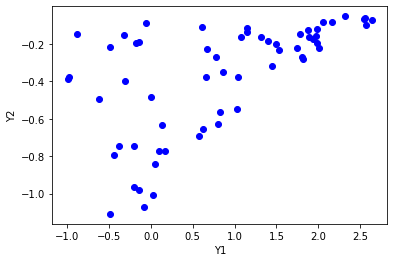

In [3]:
import plotting
plotting.plot_population(train_Y)

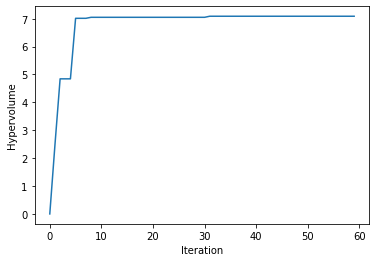

In [4]:
plotting.plot_hypervolume_over_iteration(train_Y)

In [5]:
bounds = torch.stack([torch.tensor(x_lims)[:,0], torch.tensor(x_lims)[:,1]])
bounds

tensor([[ 1.0000e-01, -2.0000e-01,  5.0000e-02,  1.0000e-02],
        [ 9.0000e-01,  2.0000e-01,  3.0000e-01,  3.5000e+01]])

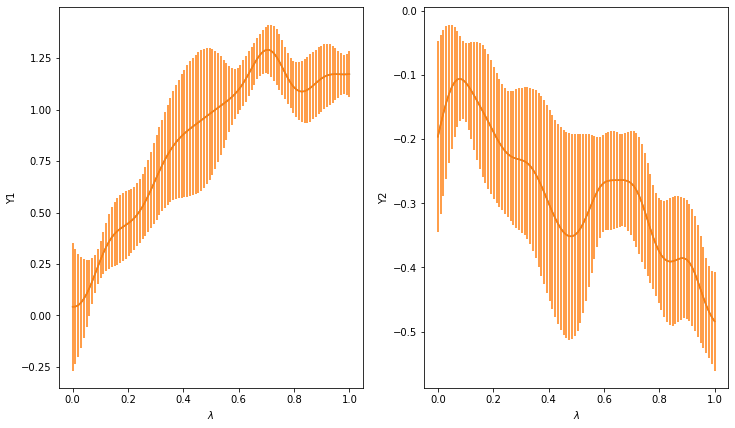

In [6]:
import plotting
def get_fitted_model(train_X,train_Y):
    train_Yvar = torch.full_like(train_Y, 0.01)
    gp= FixedNoiseGP(train_X, train_Y, train_Yvar)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp

model=get_fitted_model(train_X,train_Y)
plotting.plot_model(model,[0.5,0.0,0.15,0],[0.5,0.0,0.15,30.0])

In [12]:

from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
#print(train_X)
#print(train_Y)
N_BATCH=10
ref_point=torch.tensor([-1.0, 0.0])
for iteration in range(1, N_BATCH + 1):
    gp=get_fitted_model(train_X,train_Y)
    #gp = SingleTaskGP(train_X, train_Y)
    #test_X=torch.rand(1,4)
    #print(test_X,": ",gp.posterior(train_X).mean,"+-",gp.posterior(train_X).variance.sqrt())

    #

    #acquisition_function = UpperConfidenceBound(gp, beta=0.1)
    partitioning=FastNondominatedPartitioning(ref_point=ref_point,Y=train_Y)
    acquisition_function = ExpectedHypervolumeImprovement(
        gp, ref_point=ref_point,
        partitioning=partitioning)

    candidate, acq_value = optimize_acqf(
        acquisition_function, bounds=bounds, q=1, num_restarts=1, batch_initial_conditions=train_X
    )
    print(candidate,": ",acq_value)
    predicted_Y=gp.posterior(candidate.unsqueeze(0)).mean
    prediceted_Y_var=gp.posterior(candidate.unsqueeze(0)).variance
    print(predicted_Y,"+-",prediceted_Y_var.sqrt())
    actual_value=await evaluate_profile(candidate.tolist())
    print(actual_value)
    # add new data to training data
    train_X = torch.cat([train_X, candidate.unsqueeze(0)])
    train_Y = torch.cat([train_Y, torch.tensor(actual_value,dtype=dtype,device=device).unsqueeze(0)])
    #print(train_Y)


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.9000,  0.2000,  0.2576, 25.6058], dtype=torch.float64) :  tensor(0.0722, dtype=torch.float64)
tensor([[2.6160, 3.0087]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1367, 0.2151]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.66843, 4.141624866803403]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.9000,  0.1781,  0.2865, 25.8708], dtype=torch.float64) :  tensor(0.3229, dtype=torch.float64)
tensor([[2.5884, 4.1393]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1109, 0.1985]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.67203, 3.762569052259808]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.9000,  0.2000,  0.2732, 24.9904], dtype=torch.float64) :  tensor(0.0907, dtype=torch.float64)
tensor([[2.6743, 3.8276]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.0784, 0.1581]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.7295, 3.9538455002819846]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.9000,  0.2000,  0.2788, 24.4680], dtype=torch.float64) :  tensor(0.0507, dtype=torch.float64)
tensor([[2.6809, 3.6858]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.0812, 0.1336]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


ValueError: math domain error

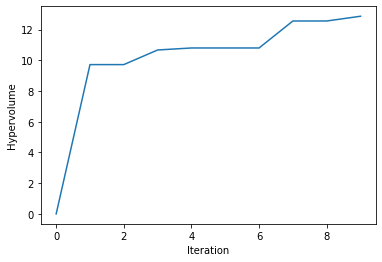

In [8]:
plotting.plot_hypervolume_over_iteration(train_Y[INITIAL_X_COUNT:,:],ref_point=ref_point)

In [14]:
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
import pandas as pd
def hypervolume(Y,ref_point=ref_point):
    # compute hypervolume of Y
    bd = DominatedPartitioning(ref_point=ref_point, Y=Y)
    hv=bd.compute_hypervolume().item()
    return hv
data=pd.DataFrame({
    "iteration":range(1,N_BATCH+1),
    "hypervolume":[hypervolume(train_Y[0:INITIAL_X_COUNT+i,:]) for i in range(1,N_BATCH+1)]
})
display(data)
print(data.to_latex(index=False))

,iteration,hypervolume
0,1,11.316594
1,2,11.316594
2,3,11.318214
3,4,11.427375
4,5,11.427375
5,6,11.427375
6,7,12.566630
7,8,12.566630
8,9,12.869930
9,10,13.421588


\begin{tabular}{rr}
\toprule
 iteration &  hypervolume \\
\midrule
         1 &    11.316594 \\
         2 &    11.316594 \\
         3 &    11.318214 \\
         4 &    11.427375 \\
         5 &    11.427375 \\
         6 &    11.427375 \\
         7 &    12.566630 \\
         8 &    12.566630 \\
         9 &    12.869930 \\
        10 &    13.421588 \\
        11 &    15.292467 \\
        12 &    15.294959 \\
        13 &    15.434722 \\
        14 &    15.434722 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_118997/35052310.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(index=False))


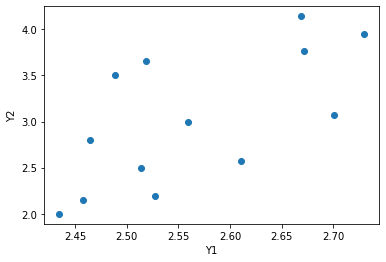

In [15]:
plotting.plot_population(train_Y[INITIAL_X_COUNT:,:])

In [11]:
print(train_X)
print(train_Y)

tensor([[ 2.0521e-01, -1.1956e-01,  1.8094e-01,  2.5450e+01],
        [ 3.9829e-01, -3.2333e-05,  2.4488e-01,  1.1208e+01],
        [ 7.2453e-01, -9.1445e-02,  2.9134e-01,  3.0470e+01],
        [ 4.1448e-01,  1.0468e-01,  1.8445e-01,  3.4339e+01],
        [ 3.9321e-01,  2.0000e-01,  1.7192e-01,  2.1397e+01],
        [ 7.3614e-01, -1.7634e-01,  7.4904e-02,  3.1845e+01],
        [ 5.7422e-01,  1.9500e-01,  2.1971e-01,  2.1381e+01],
        [ 4.7410e-01,  7.2250e-02,  1.4971e-01,  2.6659e+01],
        [ 7.5052e-01,  7.4836e-02,  1.2825e-01,  3.0318e+00],
        [ 6.0540e-01, -2.5492e-02,  2.4451e-01,  6.4324e+00],
        [ 4.7161e-01, -4.6422e-02,  2.4731e-01,  3.1468e+00],
        [ 5.3561e-01, -5.9019e-02,  8.0451e-02,  9.0017e+00],
        [ 4.1593e-01, -1.6095e-01,  2.8181e-01,  1.6926e+01],
        [ 6.1592e-01, -6.9133e-02,  1.3380e-01,  7.9757e+00],
        [ 6.2766e-01,  1.3606e-01,  1.6957e-01,  1.7585e+01],
        [ 4.5287e-01, -1.6824e-01,  2.5655e-01,  7.4871e+00],
        